# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

Выгрузим данные.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42) 

Found 7591 validated image filenames.


Иходные данные имеет следующую размерность.

In [5]:
labels.shape

(7591, 2)

Количество данных считаю досточным для выполнения поставленной задачи по определению возраста клиентов по фото.

Посмотрим распределение целевого признака.

In [6]:
def plot_hist(data, column):

    f, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={'height_ratios': (.15, .85)},
                                        figsize=(12, 7))

    sns.distplot(data[column],
                 hist=True,
                 kde=False, 
                 bins=100,
                 hist_kws={'edgecolor':'black'})
    sns.boxplot(data[column],
                ax=ax_box) 

    ax_box.set(xlabel='')
    
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title('{} distribution with hist'.format(column))
    
    plt.show()

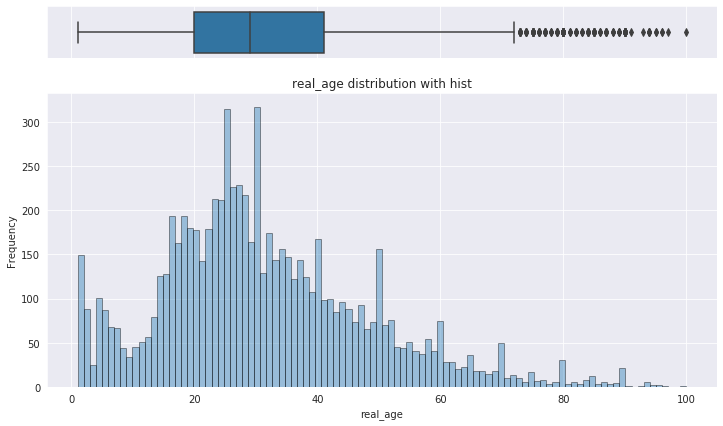

In [7]:
plot_hist(labels, 'real_age')

Распределение имеет небольшую ассиметрию, но поверить в то, что в данных представлены люди преклонного возраста возможно. Имеются некторые пики.

In [8]:
pivot_age = pd.pivot_table(labels,
                           index='real_age',
                           aggfunc='count').sort_values(by='file_name', ascending=False).head(10)

In [9]:
pivot_age

,file_name
real_age,
30,317
25,315
27,229
26,226
28,217
23,213
24,211
16,193
18,193


Больше всего фотографий, которые относятся к людям возрастом от **30** до **19**. Помимо этого можно заметить увеличенное число фотографий у людей возрастом **1**, возможно детей чаще фотографиют.

Оценим статистики.

In [10]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Выделим целевой признак.

In [11]:
features, target = next(train_gen_flow)

Посмотрим на случайные изображения из наших данных.

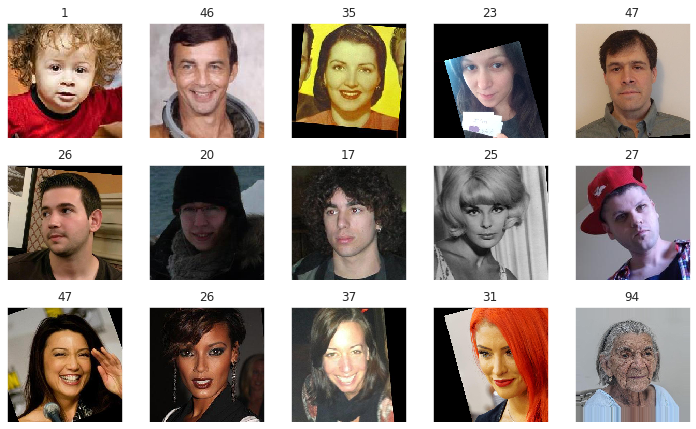

In [12]:
fig = plt.figure(figsize=(10, 10))

for i in range(15):
    
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])

Судя по фотографиям и по распределению целевого признака можно сказать, что в данных представленны люди всех возрастов - от мала до велика. Помимо этого можно отметить, что все представленные фото являются цветными и наличие исходной аугментации: повотор и добавление шумов - соль и перец. 

## Обучение модели

Для обучения воспользуемся архитектурой $ResNet50$. Стартовые веса возьмем из задачи $ImageNet$. В качестве метрики у нас будет выступать $MAE$.

Средняя абсолютная ошибка $MAE$ представляет собой сумму абсолютных различий между прогнозами и фактическими значениями. Это дает представление о том, насколько неправильными были прогнозы.

$$
MAE = \frac{1}{n} {\sum_{i=1}^{n}}{|\hat{y_i} - y_i|}
$$

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def load_train(path):
  
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path + 'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=16,
                                                 class_mode='raw',
                                                 subset='training',
                                                 seed=42)

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='raw',
                                                subset='validation',
                                                seed=42)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=1e-5)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_datagen_flow, val_datagen_flow,
                epochs=5, steps_per_epoch=None, validation_steps=None,
                batch_size=None):

    if steps_per_epoch == None:
        steps_per_epoch = len(train_datagen_flow)

    if validation_steps == None:   
        validation_steps = len(val_datagen_flow)

    model.fit(train_datagen_flow, 
              validation_data= val_datagen_flow,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              batch_size = batch_size,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 
```

```

Train for 356 steps, validate for 119 steps

Epoch 1/5
356/356 - 117s - loss: 578.6315 - mae: 18.9148 - val_loss: 979.4441 - val_mae: 26.5249

Epoch 2/5
356/356 - 39s - loss: 128.6223 - mae: 8.5057 - val_loss: 258.1253 - val_mae: 11.7861

Epoch 3/5
356/356 - 39s - loss: 79.4274 - mae: 6.7962 - val_loss: 90.6405 - val_mae: 7.3045

Epoch 4/5
356/356 - 38s - loss: 59.6809 - mae: 5.8766 - val_loss: 87.1377 - val_mae: 7.0891

Epoch 5/5
356/356 - 38s - loss: 46.6037 - mae: 5.2116 - val_loss: 84.8665 - val_mae: 7.0152
```

## Вывод

Исходные данные, представленные в виде **7591** фотографий с маркировкой возрастов. Исходя из распределения целевого признака в текущем датафрейме содержатся широкий диапазон возрастов - от **0** до **100**. При первичном осмотре было выявление применение различных методов аугментации изображений.

Таким образом, наша нейронная сеть на основе модели $ResNet50$ за пять эпох модель показала весьма неплохой результат - **7.0152** на последней эпохе.